In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import gseapy as gp

In [2]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [3]:
def kegg_enrichment(gene_list, file_name_prefix):
    # enrichment analysis
    enr = gp.enrich(gene_list,
                    gene_sets="KEGG_2021_Human",
                    outdir=None)
    # filtering p value is more than 0.05
    result = enr.res2d[enr.res2d['Adjusted P-value'] < 0.05]
    # save result
    result.to_csv(f"/mnt/c/Users/ouyangkang/Desktop/{file_name_prefix}_result.csv", index=None)

    return result

In [4]:
ctc = sc.read_h5ad('ctc_heterogeneity.h5ad')

In [8]:
ctc.obs['states'] = ['Proliverative' if i == '0' else 'others' for i in ctc.obs['leiden']]

In [13]:
res = gp.gsea(data=ctc.to_df().T, # row -> genes, column-> samples
        gene_sets="KEGG_2021_Human",
        cls=ctc.obs.states,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 8)

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [14]:
res.res2d.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Small cell lung cancer,0.512139,2.44842,0.0,0.0,0.0,26/82,6.55%,PTK2;COL4A2;LAMC1;CDKN1A;TRAF1;COL4A1;LAMA4;RB...
1,gsea,TNF signaling pathway,0.495379,2.417265,0.0,0.0,0.0,34/94,12.04%,CREB5;CCL2;TRAF1;VCAM1;SELE;ICAM1;CX3CL1;IL15;...
2,gsea,p53 signaling pathway,0.513245,2.408423,0.0,0.0,0.0,20/65,6.36%,MDM2;CDKN1A;TNFRSF10B;SESN1;PMAIP1;CDK1;SERPIN...
3,gsea,Adherens junction,0.488831,2.241485,0.0,0.001803,0.003,19/66,6.31%,PTPRM;AFDN;YES1;CTNNA1;PTPRB;FER;TGFBR2;NLK;TC...
4,gsea,Lipid and atherosclerosis,0.405992,2.151354,0.0,0.002884,0.006,38/161,7.22%,PTK2;PLCB1;PPP3CA;GSK3B;TNFRSF10B;SOD2;CCL2;TN...
5,gsea,Ribosome,-0.465558,-2.132994,0.0,0.001146,0.002,35/121,10.58%,RPL34;RPL11;RPS6;RNA5S17;RPS27;RPL37;RPL24;RPL...
6,gsea,Transcriptional misregulation in cancer,0.402616,2.130733,0.0,0.002804,0.007,52/136,18.30%,ZEB1;SMAD1;PTK2;MDM2;CDKN1A;ERG;FLT1;FUS;TRAF1...
7,gsea,Pancreatic secretion,-0.407752,-2.121345,0.0,0.000573,0.002,24/68,18.73%,RYR2;ATP1B1;PRKCB;CFTR;CA2;SLC4A4;ADCY5;CHRM3;...
8,gsea,Chronic myeloid leukemia,0.46266,2.072498,0.0,0.007211,0.021,30/68,19.03%,MDM2;CDKN1A;RB1;TGFBR2;CDK6;PIK3R3;DDB2;BCL2L1...
9,gsea,IL-17 signaling pathway,0.402672,2.044302,0.0,0.008413,0.027,26/67,16.25%,GSK3B;CCL2;MAPK8;CXCL1;MAP3K7;TRAF2;CXCL8;MAPK...


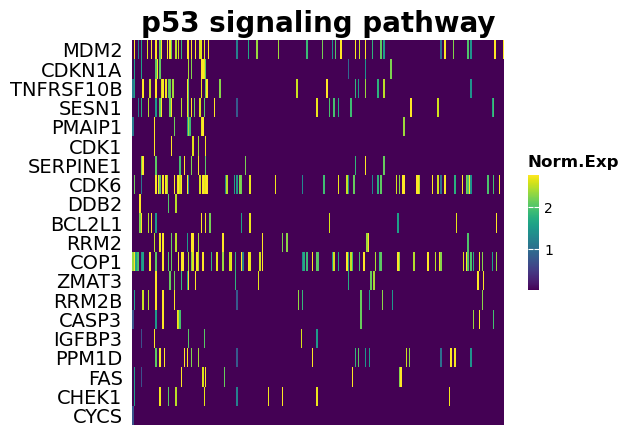

In [17]:
import matplotlib.pyplot as plt

i = 2
genes = res.res2d.Lead_genes.iloc[i].split(";")
ax = gp.heatmap(df = res.heatmat.loc[genes],
           z_score=None,
           title=res.res2d.Term.iloc[i],
           figsize=(6,5),
           cmap=plt.cm.viridis,
           xticklabels=False)

In [19]:
res.res2d.to_csv('/mnt/c/Users/ouyangkang/Desktop/ctc_gsea.csv')

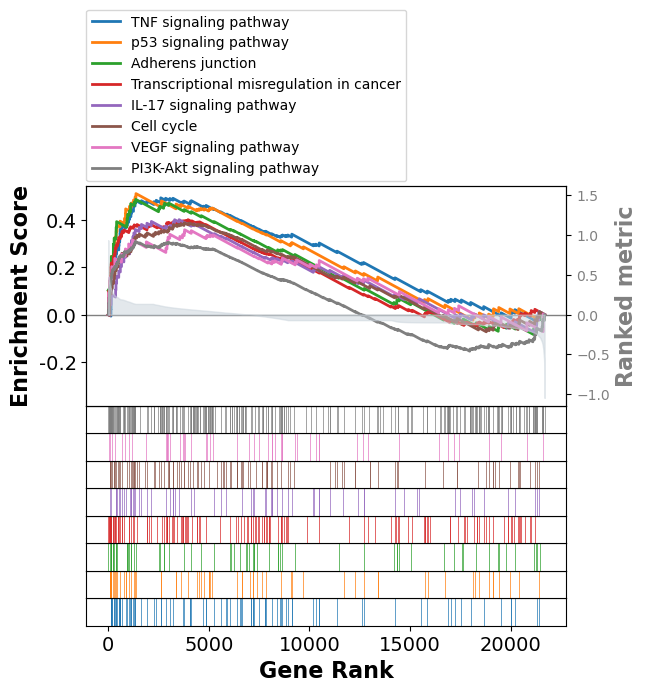

In [20]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[[1, 2, 3, 6, 9, 14, 35, 43]])

In [24]:
sc.tl.rank_genes_groups(ctc,
                        groupby='states')

In [25]:
result = ctc.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [26]:
degs.head()

,Proliverative_names,Proliverative_scores,Proliverative_pvals,Proliverative_pvals_adj,Proliverative_logfoldchanges,others_names,others_scores,others_pvals,others_pvals_adj,others_logfoldchanges
0,PTPRM,10.991979,1.008551e-16,1.671993e-13,4.767230,MTRNR2L5,15.019597,7.037415e-35,2.566686e-30,33.577900
1,TCF4,9.268236,7.057742e-14,7.800302e-11,4.068216,AC090204.1,13.967409,2.007437e-33,3.660762e-29,6.724615
2,NEAT1,8.658617,1.289825e-12,1.045389e-09,3.794602,ERBB4,13.775187,2.180071e-32,2.650385e-28,7.212790
3,CDH13,7.816035,8.233276e-11,4.691938e-08,4.539324,MTCO3P13,13.639227,1.438713e-30,8.745457e-27,32.608498
4,DOCK4,7.674377,1.912159e-10,1.010728e-07,4.711313,MTRNR2L1,13.553988,6.505308e-32,5.931540e-28,6.905361


In [27]:
degs_sig = degs[degs.Proliverative_pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.Proliverative_logfoldchanges > 0]
degs_dw = degs_sig[degs_sig.Proliverative_logfoldchanges < 0]

In [28]:
enr_up = gp.enrichr(degs_up.Proliverative_names,
                    gene_sets='GO_Molecular_Function_2025',
                    outdir=None)

In [29]:
enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]

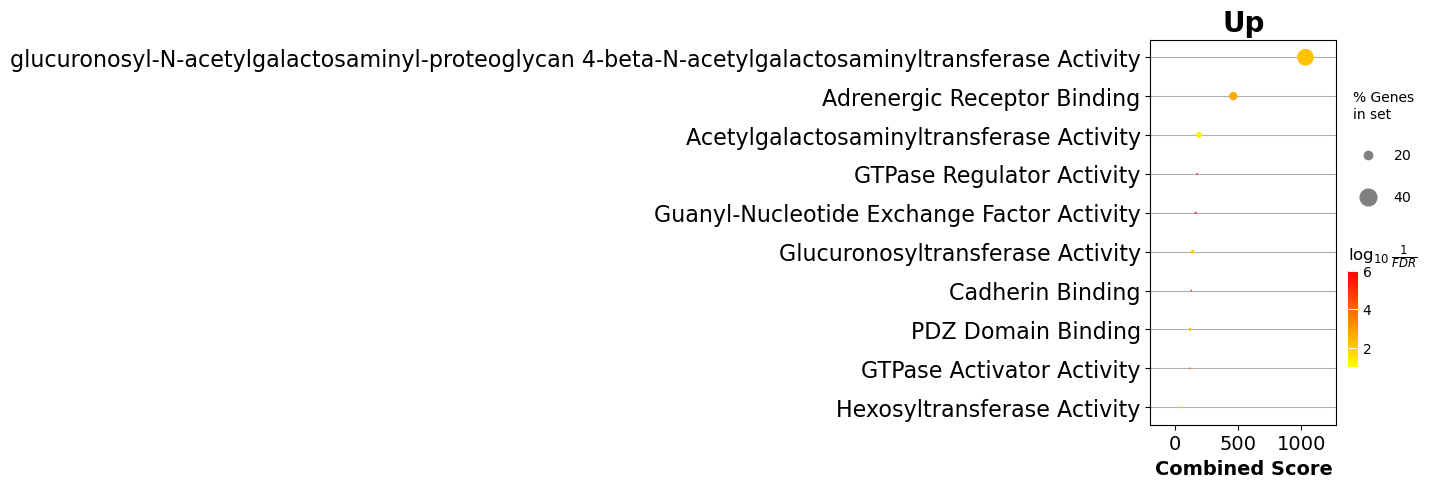

In [30]:
gp.dotplot(enr_up.res2d, figsize=(3,5), title="Up", cmap = plt.cm.autumn_r)
plt.show()

In [31]:
enr_up = gp.enrichr(degs_up.Proliverative_names,
                    gene_sets='GO_Biological_Process_2025',
                    outdir=None)

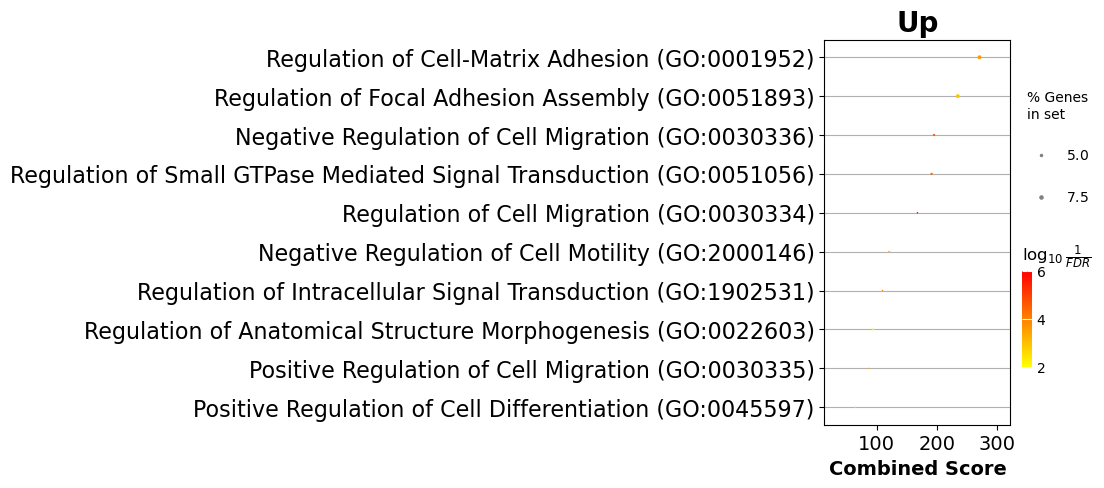

In [32]:
gp.dotplot(enr_up.res2d, figsize=(3,5), title="Up", cmap = plt.cm.autumn_r)
plt.show()

In [34]:
enr_up = gp.enrichr(degs_up.Proliverative_names,
                    gene_sets='GO_Cellular_Component_2025',
                    outdir=None)

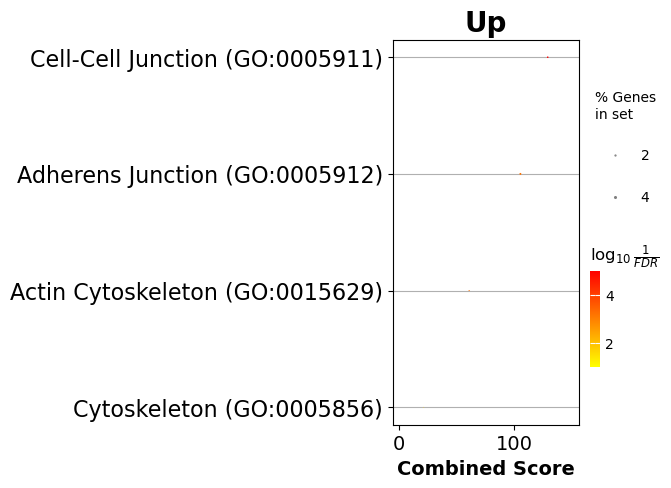

In [35]:
gp.dotplot(enr_up.res2d, figsize=(3,5), title="Up", cmap = plt.cm.autumn_r)
plt.show()

In [36]:
'TRPS1' in ctc.var_names

True

# another

In [11]:
ctc.obs['states'] = ['Proliverative' if i in ['1', '2'] else 'others' for i in ctc.obs['leiden']]

In [13]:
res = gp.gsea(data=ctc.to_df().T, # row -> genes, column-> samples
        gene_sets="KEGG_2021_Human",
        cls=ctc.obs.states,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 8)

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


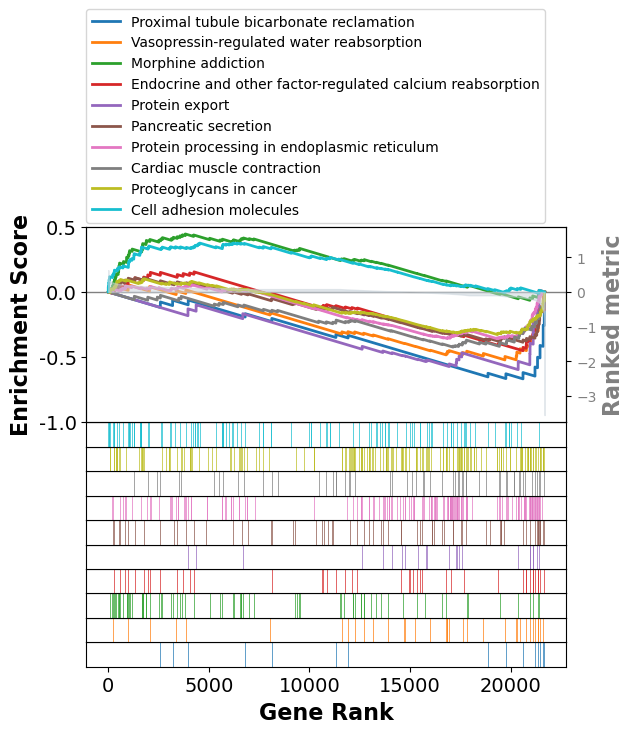

In [16]:
import matplotlib.pyplot as plt

term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[10:20])

In [17]:
ctc.obs['states'] = ['Proliverative' if i in ['3', '4'] else 'others' for i in ctc.obs['leiden']]

In [18]:
res = gp.gsea(data=ctc.to_df().T, # row -> genes, column-> samples
        gene_sets="KEGG_2021_Human",
        cls=ctc.obs.states,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 8)

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


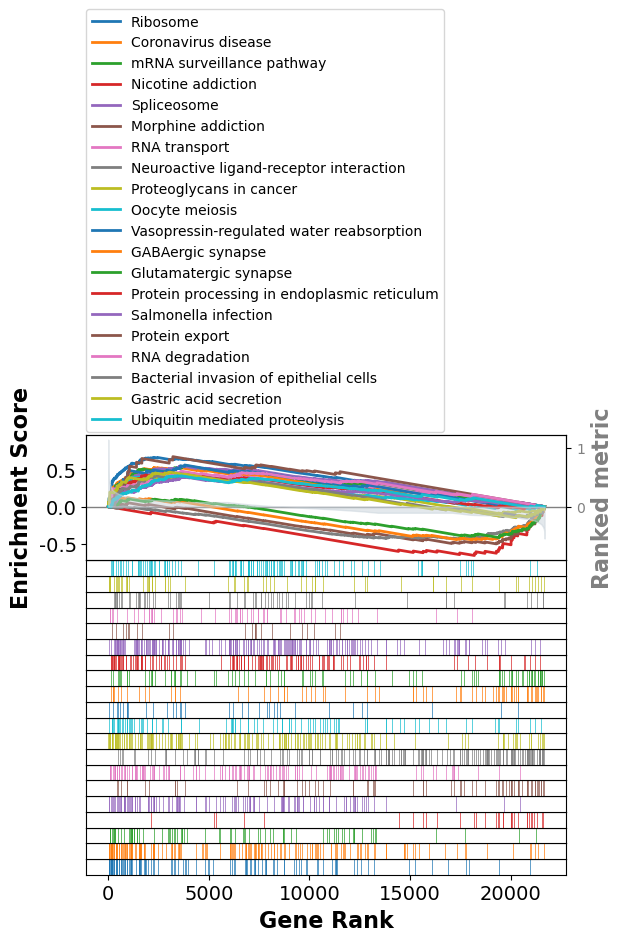

In [20]:
import matplotlib.pyplot as plt

term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[:20])